<a href="https://www.kaggle.com/code/stefansanchez26/phone-accelerometer?scriptVersionId=191331132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/edx-phone-accelerometer/test_labels.csv
/kaggle/input/edx-phone-accelerometer/test_time_series.csv
/kaggle/input/edx-phone-accelerometer/train_time_series.csv
/kaggle/input/edx-phone-accelerometer/train_labels.csv


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

dirname=('/kaggle/input/edx-phone-accelerometer')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
test_labels=pd.read_csv(dirname+'/test_labels.csv', index_col=0)
test_time_series=pd.read_csv(dirname+'/test_time_series.csv', index_col=0)
train_labels=pd.read_csv(dirname+'/train_labels.csv', index_col=0)
train_time_series=pd.read_csv(dirname+'/train_time_series.csv', index_col=0)

# Take a Quick Look at the Data

In [4]:
test_labels.head()

,timestamp,UTC time,label
24339,1565110307041,2019-08-06T16:51:47.041,NaN
24349,1565110308043,2019-08-06T16:51:48.043,NaN
24359,1565110309046,2019-08-06T16:51:49.046,NaN
24369,1565110310048,2019-08-06T16:51:50.048,NaN
24379,1565110311050,2019-08-06T16:51:51.050,NaN


In [5]:
test_time_series.head()

,timestamp,UTC time,accuracy,x,y,z
24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975
24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771
24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810
24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550


In [6]:
train_labels.head()

,timestamp,UTC time,label
20589,1565109931087,2019-08-06T16:45:31.087,1
20599,1565109932090,2019-08-06T16:45:32.090,1
20609,1565109933092,2019-08-06T16:45:33.092,1
20619,1565109934094,2019-08-06T16:45:34.094,1
20629,1565109935097,2019-08-06T16:45:35.097,1


In [7]:
train_labels.shape

(375, 3)

In [8]:
train_time_series.head()

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


In [9]:
train_time_series.shape

(3744, 6)

In [10]:
train_time_series.describe()

,timestamp,x,y,z
count,3.744000e+03,3744.000000,3744.000000,3744.000000
mean,1.565110e+12,0.195821,-1.005256,0.084435
std,1.083765e+05,0.395698,0.451178,0.350817
min,1.565110e+12,-1.071152,-3.391312,-1.415390
25%,1.565110e+12,-0.021503,-1.148064,-0.068581
50%,1.565110e+12,0.161728,-0.958015,0.052116
75%,1.565110e+12,0.400677,-0.769691,0.203800
max,1.565110e+12,2.503098,0.321747,2.587173


In [11]:
train_labels.describe()

,timestamp,label
count,3.750000e+02,375.000000
mean,1.565110e+12,2.413333
std,1.086802e+05,0.799287
min,1.565110e+12,1.000000
25%,1.565110e+12,2.000000
50%,1.565110e+12,2.000000
75%,1.565110e+12,3.000000
max,1.565110e+12,4.000000


In [12]:
train_labels[train_labels['label']==2]    #How much Walking

,timestamp,UTC time,label
20679,1565109940108,2019-08-06T16:45:40.108,2
20689,1565109941110,2019-08-06T16:45:41.110,2
20699,1565109942113,2019-08-06T16:45:42.113,2
20709,1565109943115,2019-08-06T16:45:43.115,2
20719,1565109944117,2019-08-06T16:45:44.117,2
...,...,...,...
24189,1565110292007,2019-08-06T16:51:32.007,2
24199,1565110293009,2019-08-06T16:51:33.009,2
24209,1565110294011,2019-08-06T16:51:34.011,2
24219,1565110295014,2019-08-06T16:51:35.014,2


In [13]:
train_labels.label.value_counts()

2    213
3     88
4     47
1     27
Name: label, dtype: int64

# Modifying the Data

In [14]:
time_labels = train_time_series.copy()
time_labels["label"] = train_labels["label"]
time_labels

,timestamp,UTC time,accuracy,x,y,z,label
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,NaN
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,NaN
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,NaN
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,NaN
...,...,...,...,...,...,...,...
24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304,NaN
24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213,NaN
24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713,NaN
24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805,NaN


## Fill the Unknown Labels

In [15]:
known_indices = time_labels[time_labels['label'].notnull()].index

missing_df = time_labels[time_labels['label'].isnull()]

for idx, row in missing_df.iterrows():
    closest_known_before = known_indices[known_indices < idx].max()
    closest_known_after = known_indices[known_indices > idx].min()

    if closest_known_before is not None:
        distance_before = idx - closest_known_before
    else:
        distance_before = int('inf')
    if closest_known_after is not None:
        distance_after = closest_known_after - idx
    else:
        distance_after = int('inf')

    if distance_before <= distance_after:
        time_labels.loc[idx, 'label'] = time_labels.loc[closest_known_before, 'label']
    else:
        time_labels.loc[idx, 'label'] = time_labels.loc[closest_known_after, 'label']
time_labels['label'] = time_labels['label'].astype(int)
time_labels = time_labels.sort_values(by='timestamp')


In [16]:
time_labels.head()

,timestamp,UTC time,accuracy,x,y,z,label
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,1
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,1
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,1
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1


In [17]:
time_labels['timestamp'] = round((time_labels[['timestamp']]-1565109930787)/100).astype(int)
time_labels


,timestamp,UTC time,accuracy,x,y,z,label
20586,0,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,1
20587,1,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,1
20588,2,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,1
20589,3,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1
20590,4,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1
...,...,...,...,...,...,...,...
24325,3749,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304,4
24326,3750,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213,4
24327,3751,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713,4
24328,3752,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805,4


In [18]:
time_labels.label.value_counts()

2    2130
3     880
4     465
1     269
Name: label, dtype: int64

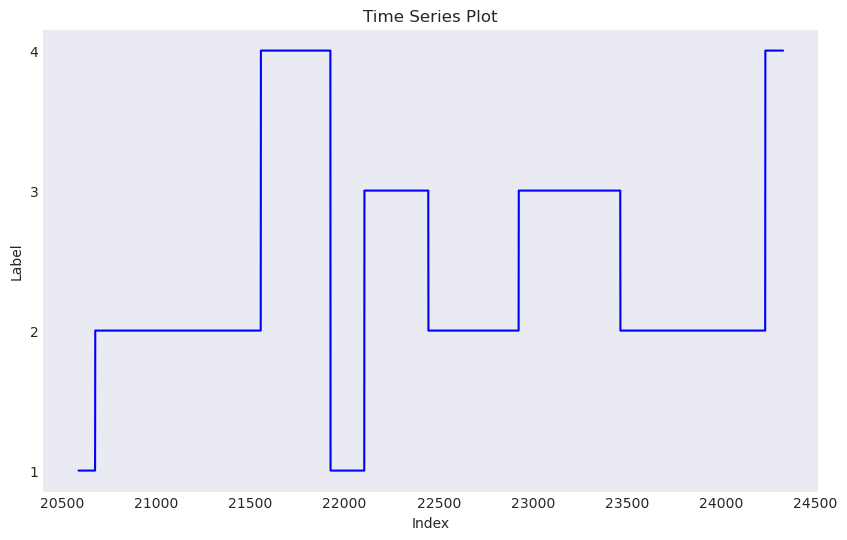

In [19]:
import matplotlib.ticker as ticker


with plt.style.context('seaborn-v0_8-dark'):
  plt.figure(figsize=(10, 6))
  plt.plot(time_labels.index, time_labels['label'], linestyle='-', color='b')
  plt.xlabel('Index')
  plt.ylabel('Label')
  plt.title('Time Series Plot')
  ax = plt.gca()
  ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
  plt.grid(False)
  plt.show()


In [20]:
X_train=train_time_series[['timestamp',"x","y","z"]]
y_train=time_labels["label"]-1 # Makes Y

# Model

In [21]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def find_best_classifier(classifiers):
    for name, clf in classifiers:
        print(f"Training and evaluating {name}...")
        scores = cross_val_score(clf, X_train, y_train,scoring="accuracy", cv=10)
        display_scores(scores)

In [22]:


classifiers = [
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Support Vector Machine", SVC(random_state=42)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("XGB Classifier", XGBClassifier(objective='multi:softmax')),
    ("Logistic Regression", LogisticRegression(multi_class='multinomial'))
]
        
find_best_classifier(classifiers)

Training and evaluating Random Forest...
Scores: [0.70133333 0.69066667 0.55466667 0.57333333 0.42513369 0.5828877
 0.4973262  0.77540107 0.70588235 0.75935829]
Mean: 0.6265989304812835
Standard deviation: 0.1108894575267192
Training and evaluating Support Vector Machine...
Scores: [0.568      0.568      0.568      0.568      0.56951872 0.56951872
 0.56951872 0.56951872 0.56951872 0.56951872]
Mean: 0.568911229946524
Standard deviation: 0.0007440161357758509
Training and evaluating K-Nearest Neighbors...
Scores: [0.53333333 1.         1.         0.848      0.71390374 1.
 0.71390374 0.93850267 0.94385027 0.56149733]
Mean: 0.8252991087344028
Standard deviation: 0.1728002339107236
Training and evaluating XGB Classifier...
Scores: [0.67733333 0.69333333 0.51733333 0.512      0.47593583 0.5828877
 0.49465241 0.74331551 0.71657754 0.7540107 ]
Mean: 0.6167379679144386
Standard deviation: 0.10540377336047602
Training and evaluating Logistic Regression...
Scores: [0.568      0.568      0.568    

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [9,10, 11, 12 ,13, 14, 15]}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid,scoring="accuracy", return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print("Best K: ", best_k)

Best K:  12


In [24]:
knn = KNeighborsClassifier(n_neighbors=best_k)
scores = cross_val_score(knn, X_train, y_train,scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.53333333 1.         1.         0.848      0.71925134 1.
 0.71657754 0.93850267 0.94385027 0.56417112]
Mean: 0.8263686274509803
Standard deviation: 0.17188160712699824
